<a href="https://colab.research.google.com/github/PranavDixit2/LungCancer/blob/main/XRay_Prod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python tensorflow
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import kagglehub
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Set destination path in your Drive
drive_dest = '/content/drive/MyDrive/lung_cancer_dataset/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
list_of_files = os.listdir(drive_dest)
print("Dataset files:", list_of_files)

Dataset files: ['chest_xray_lung']


In [ ]:
# Data Paths
root_dataset_path =  "/content/drive/MyDrive/lung_cancer_dataset/chest_xray_lung"
train_dataset_path = os.path.join(root_dataset_path, "train")
val_dataset_path   = os.path.join(root_dataset_path, "val")
test_dataset_path  = os.path.join(root_dataset_path, "test")

# Data Exploration
def explore_dataset(dataset_path):
    class_counts = {}
    total_images = 0
    for root, dirs, files in os.walk(dataset_path):
        for folder in dirs:
            folder_path = os.path.join(root, folder)
            num_files = len(os.listdir(folder_path))
            class_counts[folder] = num_files
            total_images += num_files

    print("Dataset Overview:")
    print(f"Total Classes: {len(class_counts)}")
    print(f"Total Images: {total_images}")
    print("Class Distribution:")
    for cls, count in class_counts.items():
        print(f"  {cls}: {count}")
    return class_counts

class_counts = explore_dataset(train_dataset_path)

# Data Generators
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
)

val_test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dataset_path,
    target_size=(150, 150),  # Reduced size
    batch_size=64,           # Increased batch size
    class_mode='binary',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    val_dataset_path,
    target_size=(150, 150),  # Reduced size
    batch_size=64,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dataset_path,
    target_size=(150, 150),  # Reduced size
    batch_size=64,
    class_mode='binary',
    shuffle=False
)

def get_class_weights(generator):
    labels = generator.classes
    class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    return {i: weight for i, weight in enumerate(class_weights)}
class_weights = get_class_weights(train_generator)
print(class_weights)
# Model Definition
def create_model(fine_tune=False, fine_tune_at=140):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))  # Adjusted input shape
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(150, 150, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)

    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    if fine_tune:
        base_model.trainable = True
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
        model.compile(optimizer=Adam(learning_rate=1e-4),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
    return model

# Instantiate model
model = create_model(fine_tune=False)
model.summary()

# Helper function to extract data and labels from a generator
def extract_data_and_labels(generator):
    data = []
    labels = []
    for _ in range(len(generator)):
        images, batch_labels = next(generator)
        data.append(images)
        labels.append(batch_labels)
    return np.vstack(data), np.concatenate(labels)

train_data, train_labels = extract_data_and_labels(train_generator)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("/content/drive/MyDrive/lung_cancer_model.keras", save_best_only=True, monitor='val_loss'),  # Changed to .keras format
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-5)

# Using 5-fold cross-validation for robustness
kf = KFold(n_splits=2, shuffle=True, random_state=42)
fold_no = 1

for train_idx, val_idx in kf.split(train_data, train_labels):
    print(f"\n--- Training Fold {fold_no} ---")
    fold_train_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input).flow(
        train_data[train_idx], train_labels[train_idx], batch_size=64  # Increased batch size
    )
    fold_val_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input).flow(
        train_data[val_idx], train_labels[val_idx], batch_size=64  # Increased batch size
    )

    model = create_model(fine_tune=False)
    history = model.fit(
        fold_train_gen,
        epochs=3,  # Reduced number of epochs
        validation_data=fold_val_gen,
        class_weight=class_weights,
        callbacks=[early_stopping, model_checkpoint, reduce_lr]
    )

    val_loss, val_acc = model.evaluate(fold_val_gen)
    print(f"Fold {fold_no} - Validation Accuracy: {val_acc:.2f}")
    fold_no += 1



Dataset Overview:
Total Classes: 2
Total Images: 5216
Class Distribution:
  Cancer: 3875
  NORMAL: 1341
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
{0: np.float64(0.6730322580645162), 1: np.float64(1.9448173005219984)}


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 5, 5, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


--- Training Fold 1 ---
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 311s 7s/step - accuracy: 0.6999 - loss: 0.9132 - val_accuracy: 0.9387 - val_loss: 0.1516 - learning_rate: 0.0010
Epoch 2/3
41/41 ━━━━━━━━━━━━━━━━━━━━ 296s 7s/step - accuracy: 0.9374 - loss: 0.1551 - val_accuracy: 0.9490 - val_loss: 0.1323 - learning_rate: 0.0010
Epoch 3/3
41/41 ━━━━━━━━━━━━━━━━━━━━ 291s 7s/step - accuracy: 0.9494 - loss: 0.1338 - val_accuracy: 0.9505 - val_loss: 0.1243 - learning_rate: 0.0010
41/41 ━━━━━━━━━━━━━━━━━━━━ 145s 4s/step - accuracy: 0.9513 - loss: 0.1280
Fold 1 - Validation Accuracy: 0.95

--- Training Fold 2 ---
Epoch 1/3
41/41 ━━━━━━━━━━━━━━━━━━━━ 307s 7s/step - accuracy: 0.7427 - loss: 0.5758 - val_accuracy: 0.9367 - val_loss: 0.1631 - learning_rate: 0.0010
Epoch 2/3
41/41 ━━━━━━━━━━━━━━━━━━━━ 295s 7s/step - accuracy: 0.9311 - loss: 0.1572 - val_accuracy: 0.9363 - val_loss: 0.1604 - learning_rate: 0.0010
Epoch 3/3
41/41 ━━━━━━━━━━━━━━━━━━━━ 293s 7s/step - accuracy: 0.9290 - loss: 0.1454 - val_accuracy: 0.9433 - val_loss: 0.1460 

UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7cfe710135b0>
Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py", line 248, in _finite_generator
    yield self._standardize_batch(self.py_dataset[i])
                                  ~~~~~~~~~~~~~~~^^^

  File "/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py", line 68, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py", line 313, in _get_batches_of_transformed_samples
    img = image_utils.load_img(
          ^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/image_utils.py", line 236, in load_img
    img = pil_image.open(io.BytesIO(f.read()))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/PIL/Image.py", line 3572, in open
    raise UnidentifiedImageError(msg)

PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7cfe710135b0>


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_multi_step_on_iterator_42837]

In [ ]:
from PIL import Image, UnidentifiedImageError

def clean_invalid_images(directory):
    removed_files = []
    for root, _, files in os.walk(directory):
        for fname in files:
            file_path = os.path.join(root, fname)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # Verify if it's a valid image
            except (UnidentifiedImageError, OSError, IOError):
                removed_files.append(file_path)
                os.remove(file_path)
    print(f"Removed {len(removed_files)} corrupted or invalid images.")
    return removed_files

# Clean train, val, and test directories
clean_invalid_images(train_dataset_path)
clean_invalid_images(val_dataset_path)
clean_invalid_images(test_dataset_path)


Removed 0 corrupted or invalid images.
Removed 0 corrupted or invalid images.
Removed 1 corrupted or invalid images.


['/content/drive/MyDrive/lung_cancer_dataset/chest_xray_lung/test/Cancer/test_cancer225.jpeg']

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.9294 - loss: 0.2013
Test Accuracy: 0.89


10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step
              precision    recall  f1-score   support

      Cancer       0.88      0.96      0.91       389
      NORMAL       0.91      0.77      0.84       234

    accuracy                           0.89       623
   macro avg       0.89      0.86      0.88       623
weighted avg       0.89      0.89      0.89       623

AUC-ROC: 0.95


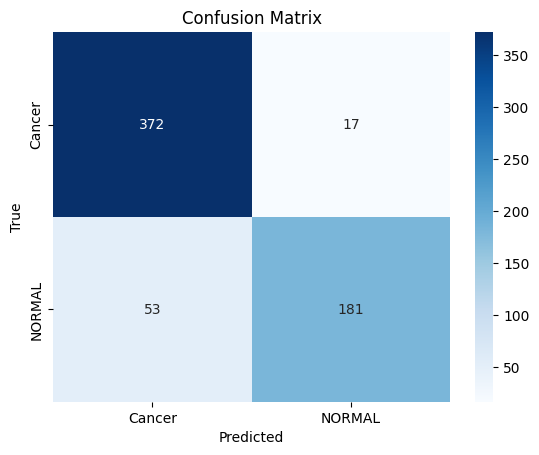

In [ ]:
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()
y_true = test_generator.classes

print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))
auc = roc_auc_score(y_true, y_pred_probs)
print(f"AUC-ROC: {auc:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()